# ANÁLISIS DE SENTIMIENTO Y CATEGORIZACIÓN DE TEXTO (MODELO NO ENTRENADO Y CLASIFICANDO POR POLARIZACIÓN)

In [1]:
### LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Descargar recursos de NLTK 
nltk.download('punkt')
nltk.download('wordnet')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()


c:\Users\joey_\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joey_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joey_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# MODELO BERT PARA ANÁLISIS DE TEXTO

sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


Device set to use cpu


In [3]:
### FUENTE DE DATOS

file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/Data%20Sources/Comments.csv'
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

# Limpieza: eliminar filas donde 'TRANSLATED COMMENTS' solo contiene "..." o está vacía
df = df[~df["TRANSLATED COMMENTS"].str.strip().isin(["", "..."])]


In [4]:
### ANÁLISIS DE SENTIMIENTOS Y ASIGNACIÓN DE ISSUES

def analyze_sentiment(comment):
    comment = str(comment).strip()
    if not comment or comment == "nan":
        return "NEUTRAL", 0.0
    result = sentiment_analyzer(comment, truncation=True, max_length=512)[0]
    label = result['label']
    score = result['score']
    if label == "POSITIVE":
        polarity = score
        sentiment = "Positive" if score > 0.7 else "Neutral"
    else:
        polarity = -score
        sentiment = "Negative" if score > 0.7 else "Neutral"
    return sentiment, polarity

df[['sentiment', 'polarity']] = df["TRANSLATED COMMENTS"].apply(analyze_sentiment).apply(pd.Series)

print("Distribución de sentimientos:")
print(df['sentiment'].value_counts())

df_nn = df[df['sentiment'].isin(['Negative', 'Neutral'])].copy()
comments_nn = df_nn["TRANSLATED COMMENTS"].tolist()
print(f"\nNúmero de comentarios Negativos y Neutrales: {len(comments_nn)}")

print("\nEjemplos de comentarios con puntajes:")
print(df[["TRANSLATED COMMENTS", 'sentiment', 'polarity']].head(10))

# Listado predefinido de issues y sus palabras clave para clasificar comentarios por tópicos

predefined_issues = {
    "Slow Response/Delay Issues": ["faster","feedback","slow", "answer", "solution" , "wait", "long", "wait", "late", "take", "forever", "reply", "frustrate"],
    "Poor Agent Knowledge": ["know", "prepare", "confuse", "wrong", "incompetent", "expert"],
    "Poor Support Quality": ["rude", "help", "attitude", "confuse", "incompetent", "understand", "agent"],
    "Fraud/Trust Issues": ["fraud", "scam", "trust", "secure", "money", "pay", "fake", "hack", "safe"],
    "Product and Services": ["account", "service", "term", "policy", "product", "avail", "refund"],
    "Platform Functionality": ["app","api","platform", "system", "error", "bug", "crash", "technical", "happen"],
    "Lack of Communication Channels": ["phone", "email", "contact", "call", "chat", "verbal","operator","agent"],
    "Lack of Response": ["assistance","receive","any","request", "support" ,"contact","respond", "answer", "no one", "get", "feedback", "question", "nobody", "silent","call"],
    "Ineffective Resolution": ["unsuccessful","request","resolve", "problem", "solve", "fix", "nothing", "resolution"],
    "Language Barriers": ["portuguese", "help", "speaker", "native", "spanish", "english", "language", "italian", "translate", "speak"]
}



def lemmatize_text(text):
    words = word_tokenize(text.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    return lemmatized_words

# Asignación de issues a los comentarios

def assign_issue(comment):
    comment_words = lemmatize_text(comment)
    max_overlap = 0
    best_issue = "Other Issues"
    for issue, issue_keywords in predefined_issues.items():
        overlap = len(comment_words.intersection(set(issue_keywords)))
        if overlap > max_overlap or (overlap == max_overlap and issue in ["Lack of Response", "Language Barriers", "Platform Functionality", "Poor Support Quality", "Poor Agent Knowledge", "Product and Services", "Fraud/Trust Issues", "Lack of Communication Channels"]):
            max_overlap = overlap
            best_issue = issue
    return best_issue if max_overlap > 0 else "Other Issues"


df_nn['issue'] = df_nn["TRANSLATED COMMENTS"].apply(assign_issue)

# Visualización de comentarios con sus sentimientos y issues asignados

print("\nComentarios con sus issues asignados:")
print(df_nn[["TRANSLATED COMMENTS", 'sentiment', 'polarity', 'issue']])


Distribución de sentimientos:
sentiment
Negative    177
Positive    127
Neutral       6
Name: count, dtype: int64

Número de comentarios Negativos y Neutrales: 183

Ejemplos de comentarios con puntajes:
                                  TRANSLATED COMMENTS sentiment  polarity
1                       ...but your reply was good :)  Positive  0.994082
2                    ...I didn't even get a response!  Negative -0.999758
3                       2 weeks and no resolution yet  Negative -0.998362
4                A little late but perfect in the end  Positive  0.999673
5                      A wonderful support. Thank you  Positive  0.999871
6   Above all, I have the impression that it was a...  Positive  0.919808
7           Accurate Fast Perfect Thank you very much  Positive  0.999876
8   After a few days I found out on my own how to ...  Negative -0.999192
9                       all super and thanks for help  Positive  0.999541
10              All the information was very complete  Po

C:\Users\joey_\AppData\Local\Temp\ipykernel_5964\2587395005.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_percentages.index, y=sentiment_percentages.values, palette=sentiment_colors)


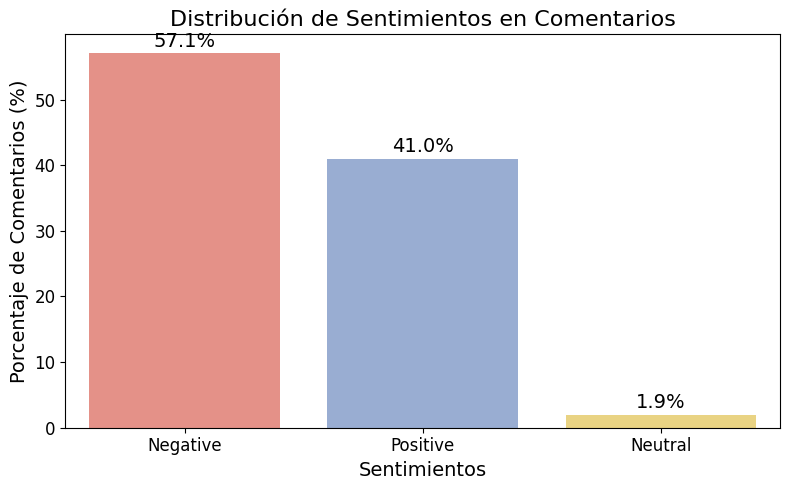

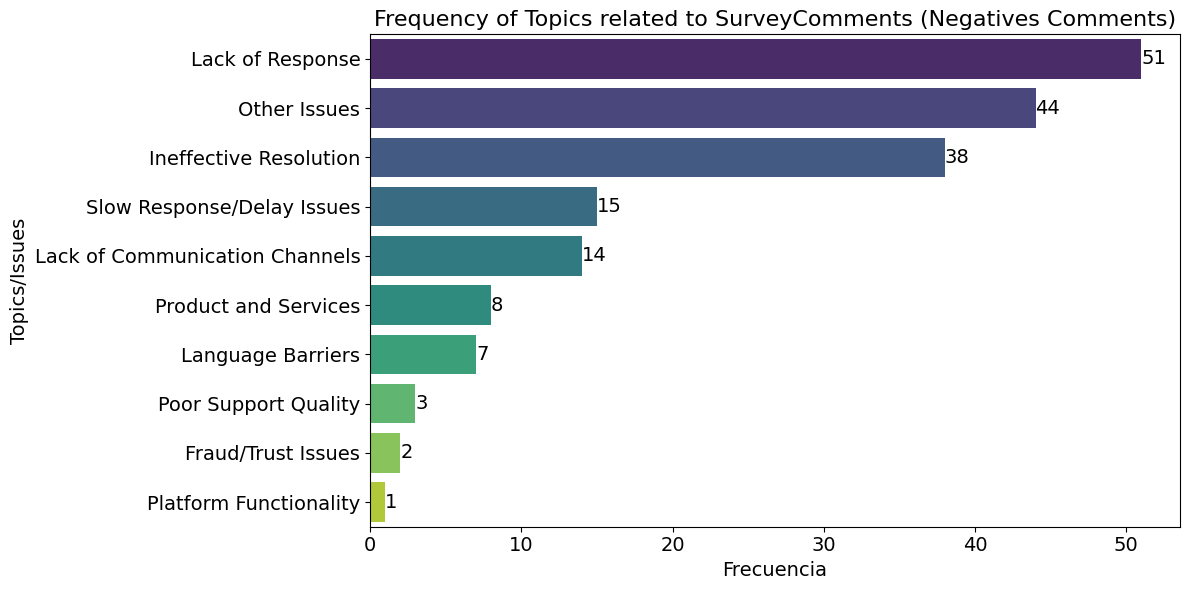

In [5]:

### VISUALIZACIÓN DE GRÁFICOS DE SENTIMIENTOS E ISSUES

## PROPORCIÓN DE SENTIMIENTOS

sentiment_colors = {
    'Positive': '#8FAADC',
    'Neutral': '#FADD72',
    'Negative': '#F38579'
}


sentiment_counts = df['sentiment'].value_counts()
total_comments = sentiment_counts.sum()


sentiment_percentages = (sentiment_counts / total_comments) * 100


plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_percentages.index, y=sentiment_percentages.values, palette=sentiment_colors)
plt.xlabel('Sentimientos', size=14)
plt.ylabel('Porcentaje de Comentarios (%)', size=14)
plt.title('Distribución de Sentimientos en Comentarios', size=16)


for i, v in enumerate(sentiment_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', size=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## CANTIDAD DE ISSUES PARA COMENTARIOS NEGATIVOS Y NEUTRALES 

plt.figure(figsize=(12, 6))
issue_counts = df_nn['issue'].value_counts()
sns.barplot(x=issue_counts.values, y=issue_counts.index, palette="viridis", hue=issue_counts.index)
plt.xlabel('Frecuencia', size=14)
plt.ylabel('Topics/Issues', size=14)
plt.title('Frequency of Topics related to SurveyComments (Negatives Comments)', size=16)
for i, v in enumerate(issue_counts.values):
    plt.text(v, i, str(v), va='center', size=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
df_nn.head(25)

,TRANSLATED COMMENTS,sentiment,polarity,issue
2,...I didn't even get a response!,Negative,-0.999758,Lack of Response
3,2 weeks and no resolution yet,Negative,-0.998362,Ineffective Resolution
8,After a few days I found out on my own how to ...,Negative,-0.999192,Ineffective Resolution
16,assistance on missed collections.,Negative,-0.985095,Lack of Response
17,At first it seemed like he didn't understand w...,Negative,-0.996610,Lack of Communication Channels
18,bad,Negative,-0.999782,Other Issues
19,Basically a nice chat but the answer was compl...,Negative,-0.997492,Fraud/Trust Issues
20,being a bit faster in answering.,Neutral,-0.661157,Slow Response/Delay Issues
21,Call with Italian operator,Negative,-0.766389,Lack of Communication Channels
22,Cancel my Stripe account,Negative,-0.999675,Product and Services


SOLO NEGATIVOS

In [ ]:
##df_nn.to_excel('C:/Users/joey_/Desktop/DESK 2025/DB (RESPALDOS)/Sentiments and Topics.xlsx', index=False)

# MODELO DE ANÁLISIS DE SENTIMIENTO BERT (ENTRENADO)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch


In [ ]:


# 3. Cargar el dataset de Hugging Face
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

for split in dataset.keys():
    dataset[split] = dataset[split].shuffle(seed=42).select(range(int(0.05 * len(dataset[split]))))

# 4. Preprocesar los datos
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizar los datasets
def tokenize_function(examples):
    return tokenizer([str(text) for text in examples['text']], padding="max_length", truncation=True)

# Tokenizar los datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 5. Preparar los datos para el entrenamiento
def label_to_int(label):
    if label == "positive":
        return 0
    elif label == "neutral":
        return 1
    elif label == "negative":
        return 2
    else:
        return -1  # Para manejar etiquetas no válidas

# Convertir las etiquetas a enteros
tokenized_datasets = tokenized_datasets.map(lambda x: {'label': label_to_int(x['sentiment'])})

# 6. Entrenar un modelo de análisis de sentimientos
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Aumentar el tamaño del batch
    per_device_eval_batch_size=32,
    num_train_epochs=0.5,  # Mantener bajo para pruebas
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=15,  # Aumentar el intervalo de logging
    load_best_model_at_end=True,
    fp16=True,  # Habilitar mixed precision
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

# Entrenar el modelo
trainer.train()

# 7. Evaluar el modelo
trainer.evaluate()

In [ ]:

# 8. Cargar el CSV de producción
file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/Data%20Sources/Comments.csv'
df_production = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
df_production['TRANSLATED COMMENTS'] = df_production['TRANSLATED COMMENTS'].astype(str)

# Tokenizar los comentarios de producción
production_encodings = tokenizer(df_production['TRANSLATED COMMENTS'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Hacer predicciones
with torch.no_grad():
    outputs = model(**production_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Agregar las predicciones al DataFrame
df_production['predicted_sentiment'] = predictions.numpy()

# 9. Visualizar resultados
print(df_production[['TRANSLATED COMMENTS', 'predicted_sentiment']].head(10))

# Visualización de la distribución de sentimientos
sentiment_counts = df_production['predicted_sentiment'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.xlabel('Sentimientos', size=14)
plt.ylabel('Número de Comentarios', size=14)
plt.title('Distribución de Sentimientos en Comentarios de Producción', size=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
